In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Config
original_dim = 28 * 28
intermediate_dim1 = 256
intermediate_dim2 = 128
intermediate_dim3 = 64
latent_dim = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(original_dim, intermediate_dim1)
        self.fc2 = nn.Linear(intermediate_dim1, intermediate_dim2)
        self.fc3 = nn.Linear(intermediate_dim2, intermediate_dim3)
        self.z_mean = nn.Linear(intermediate_dim3, latent_dim)
        self.z_log_var = nn.Linear(intermediate_dim3, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        z = z_mean + eps * std
        return z_mean, z_log_var, z

# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, intermediate_dim3)
        self.fc2 = nn.Linear(intermediate_dim3, intermediate_dim2)
        self.fc3 = nn.Linear(intermediate_dim2, intermediate_dim1)
        self.fc4 = nn.Linear(intermediate_dim1, original_dim)

    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return torch.sigmoid(self.fc4(x))

# VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z_mean, z_log_var

def vae_loss(x, x_recon, z_mean, z_log_var):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return recon_loss + kl_loss


In [4]:
# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def flatten_dataset(dataset):
    data = dataset.data.float() / 255.
    data = data.view(-1, 28 * 28)
    return TensorDataset(data)

train_loader = DataLoader(flatten_dataset(train_dataset), batch_size=32, shuffle=True)
test_loader  = DataLoader(flatten_dataset(test_dataset), batch_size=32)

# Model setup
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
for epoch in range(1, 51):
    vae.train()
    train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_recon, z_mean, z_log_var = vae(x)
        loss = vae_loss(x, x_recon, z_mean, z_log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset):.4f}')


100%|██████████| 9.91M/9.91M [00:00<00:00, 125MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 26.1MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 40.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.15MB/s]


Epoch 1, Loss: 172.7166
Epoch 2, Loss: 134.0020
Epoch 3, Loss: 124.4307
Epoch 4, Loss: 120.6426
Epoch 5, Loss: 118.4807
Epoch 6, Loss: 116.9951
Epoch 7, Loss: 115.9754
Epoch 8, Loss: 115.1107
Epoch 9, Loss: 114.3953
Epoch 10, Loss: 113.8300
Epoch 11, Loss: 113.3783
Epoch 12, Loss: 112.9267
Epoch 13, Loss: 112.5438
Epoch 14, Loss: 112.2083
Epoch 15, Loss: 111.9482
Epoch 16, Loss: 111.6246
Epoch 17, Loss: 111.4604
Epoch 18, Loss: 111.2457
Epoch 19, Loss: 111.0272
Epoch 20, Loss: 110.8301
Epoch 21, Loss: 110.6812
Epoch 22, Loss: 110.5200
Epoch 23, Loss: 110.3885
Epoch 24, Loss: 110.1777
Epoch 25, Loss: 110.0904
Epoch 26, Loss: 109.9457
Epoch 27, Loss: 109.8654
Epoch 28, Loss: 109.7536
Epoch 29, Loss: 109.6300
Epoch 30, Loss: 109.5390
Epoch 31, Loss: 109.4479
Epoch 32, Loss: 109.3497
Epoch 33, Loss: 109.2555
Epoch 34, Loss: 109.1771
Epoch 35, Loss: 109.0758
Epoch 36, Loss: 109.0153
Epoch 37, Loss: 108.9818
Epoch 38, Loss: 108.8286
Epoch 39, Loss: 108.8017
Epoch 40, Loss: 108.7299
Epoch 41,

In [5]:
vae.eval()
with torch.no_grad():
    x_test = test_dataset.data.float().view(-1, 28*28) / 255.
    x_test = x_test.to(device)
    z_mean, _, _ = vae.encoder(x_test)
    x_test_encoded = z_mean.cpu().numpy()


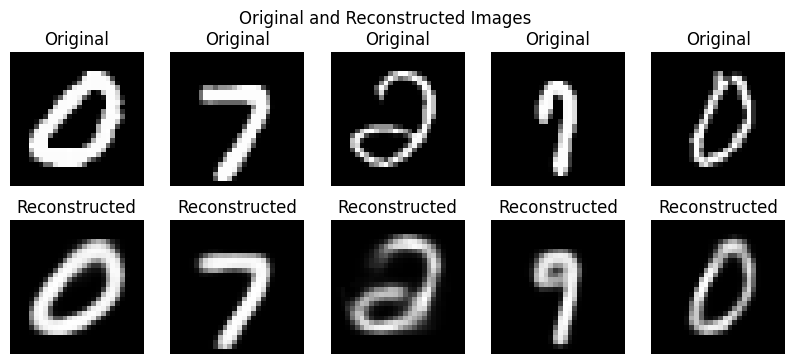

In [6]:
# Function to plot images
def plot_images(original, reconstructed, num_images, title):
    plt.figure(figsize=(num_images * 2, 4))
    for i in range(num_images):
        # Plot original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Plot reconstructed images
        ax = plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Select 5 random images from the test set
num_images = 5
random_indices = np.random.choice(len(x_test), num_images, replace=False)
x_test_sample = x_test[random_indices]

# Use the trained VAE to reconstruct the selected images
with torch.no_grad():
    reconstructed_images,_,_ = vae(x_test_sample)

# Plot the original and reconstructed images
plot_images(x_test_sample, reconstructed_images.cpu(), num_images, 'Original and Reconstructed Images')

In [7]:
reconstructed_images.shape

torch.Size([5, 784])

In [8]:
# Function to plot images
def plot_images_grid(original, instantiations, num_images, num_rows=4):
    plt.figure(figsize=(num_images * 2, num_rows * 2))
    for i in range(num_images):
        # Plot original images
        ax = plt.subplot(num_rows, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Plot instantiations
        for j in range(1, num_rows):
            ax = plt.subplot(num_rows, num_images, j * num_images + i + 1)
            plt.imshow(instantiations[j - 1][i].reshape(28, 28), cmap='gray')
            if i == 0:
                ax.set_ylabel(f'Instance {j}', rotation=0, labelpad=30, va='center')
            plt.axis('off')
    plt.suptitle('Original and Instantiations from Latent Space')
    plt.show()

/tmp/ipython-input-9-4022455282.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_sample = z_mean[i] + np.exp(z_log_sigma[i]) * epsilon


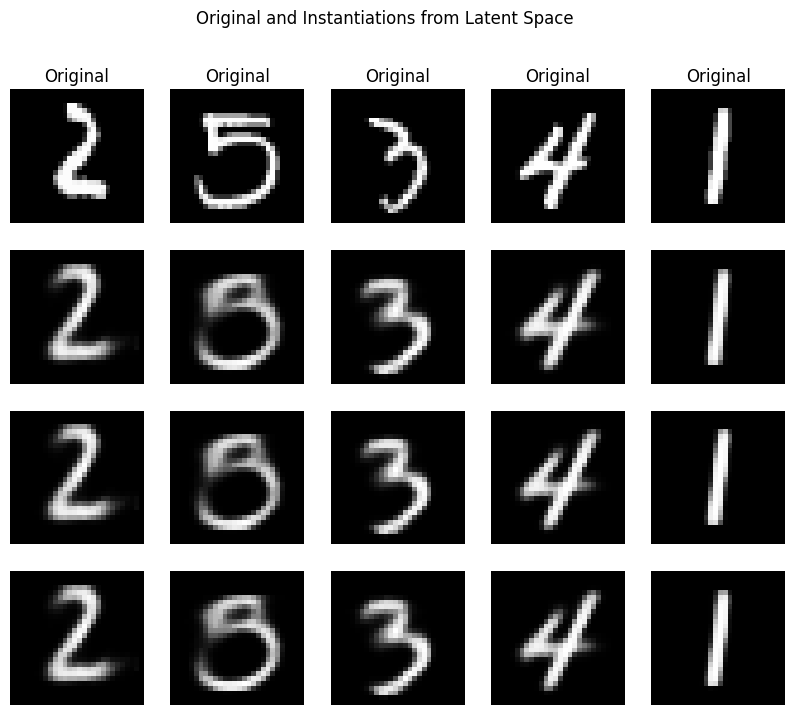

In [9]:
with torch.no_grad():
    # Select 5 random images from the test set
    num_images = 5
    random_indices = np.random.choice(len(x_test), num_images, replace=False)
    x_test_sample = x_test[random_indices]

    # Encode the selected images to get their latent representations
    z_mean, z_log_sigma, _ = vae.encoder(x_test_sample)

    # Generate multiple instantiations from the latent representations
    num_instantiations = 3
    instantiations = []
    for _ in range(num_instantiations):
        sampled_images = []
        for i in range(num_images):
            epsilon = np.random.normal(size=(1, latent_dim))
            z_sample = z_mean[i] + np.exp(z_log_sigma[i]) * epsilon
            generated_image = vae.decoder(z_sample.float())
            sampled_images.append(generated_image)
        instantiations.append(np.array(sampled_images).squeeze())

    # Plot the original and instantiations in a 4x5 grid
    plot_images_grid(x_test_sample, instantiations, num_images)

In [10]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 64, 7, 7)
        x = self.deconv(x)
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        recon = self.decoder(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


In [11]:
# Load MNIST
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

vae2 = VAE(latent_dim=32).to(device)
optimizer = torch.optim.Adam(vae2.parameters(), lr=1e-3)


for epoch in range(20):
    vae2.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        recon, mu, logvar = vae2(images)
        loss = vae_loss(recon, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader.dataset):.4f}")



100%|██████████| 26.4M/26.4M [00:01<00:00, 21.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 335kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.17MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.1MB/s]


Epoch 1, Loss: 280.5422
Epoch 2, Loss: 252.5149
Epoch 3, Loss: 248.5980
Epoch 4, Loss: 246.5732
Epoch 5, Loss: 245.2332
Epoch 6, Loss: 244.2305
Epoch 7, Loss: 243.4263
Epoch 8, Loss: 242.9542
Epoch 9, Loss: 242.4716
Epoch 10, Loss: 242.0716
Epoch 11, Loss: 241.7149
Epoch 12, Loss: 241.4855
Epoch 13, Loss: 241.2068
Epoch 14, Loss: 240.9862
Epoch 15, Loss: 240.7508
Epoch 16, Loss: 240.5734
Epoch 17, Loss: 240.4010
Epoch 18, Loss: 240.2719
Epoch 19, Loss: 240.0916
Epoch 20, Loss: 240.0076
Epoch 21, Loss: 239.8685
Epoch 22, Loss: 239.7517
Epoch 23, Loss: 239.6414
Epoch 24, Loss: 239.5751
Epoch 25, Loss: 239.4672
Epoch 26, Loss: 239.3642
Epoch 27, Loss: 239.3278
Epoch 28, Loss: 239.2524
Epoch 29, Loss: 239.1517
Epoch 30, Loss: 239.0865
Epoch 31, Loss: 239.0190
Epoch 32, Loss: 238.9564
Epoch 33, Loss: 238.8640
Epoch 34, Loss: 238.8533
Epoch 35, Loss: 238.7919
Epoch 36, Loss: 238.6806
Epoch 37, Loss: 238.6683
Epoch 38, Loss: 238.6230
Epoch 39, Loss: 238.5779
Epoch 40, Loss: 238.5115
Epoch 41,

In [13]:
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [15]:
vae2.eval()
with torch.no_grad():
    x_test = test_dataset.data.float().view(-1, 28*28) / 255.
    x_test = x_test.to(device)
    z_mean, _, _ = vae.encoder(x_test)
    x_test_encoded = z_mean.cpu().numpy()

/tmp/ipython-input-17-1415669695.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_sample = torch.tensor(x_test_sample).float().view(-1, 1, 28, 28).to(device)


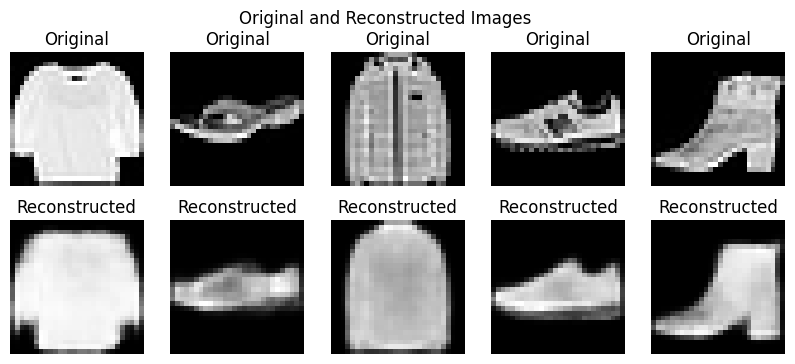

In [17]:
# Select 5 random images from the test set
num_images = 5
random_indices = np.random.choice(len(x_test), num_images, replace=False)
x_test_sample = torch.tensor(x_test_sample).float().view(-1, 1, 28, 28).to(device)

# Gerar as reconstruções com o VAE
with torch.no_grad():
    reconstructed_images, _, _ = vae2(x_test_sample)

# Plotar
plot_images(x_test_sample.cpu(), reconstructed_images.cpu(), num_images, 'Original and Reconstructed Images')

/tmp/ipython-input-20-1825012198.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_sample = torch.tensor(x_test_sample).float().view(-1, 1, 28, 28).to(device)
/tmp/ipython-input-20-1825012198.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_sample = z_mean[i] + np.exp(z_log_sigma[i]) * epsilon


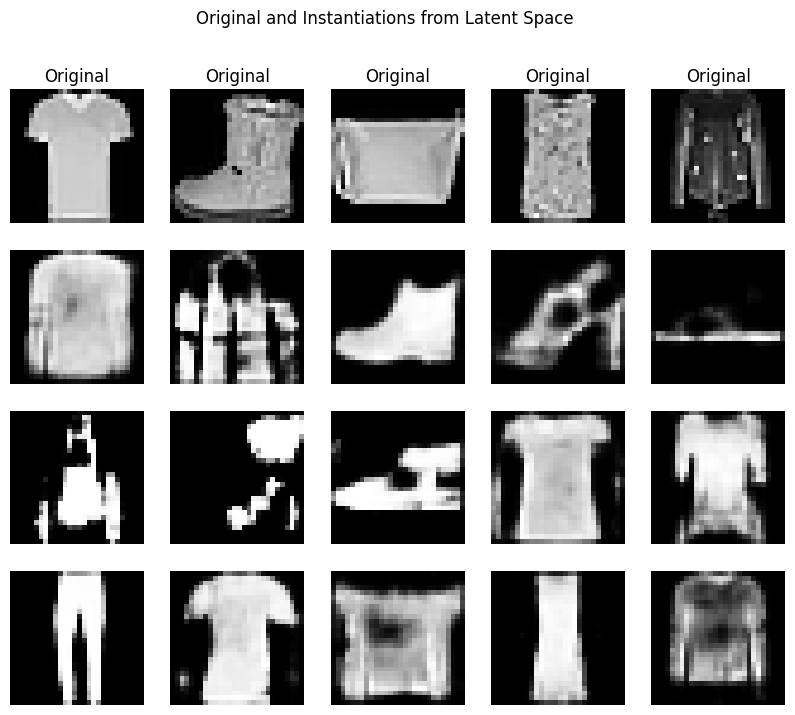

In [20]:
with torch.no_grad():
    # Select 5 random images from the test set
    num_images = 5
    random_indices = np.random.choice(len(x_test), num_images, replace=False)
    x_test_sample = torch.tensor(x_test_sample).float().view(-1, 1, 28, 28).to(device)

    # Encode the selected images to get their latent representations
    z_mean, z_log_sigma, _ = vae2.encoder(x_test_sample)

    # Generate multiple instantiations from the latent representations
    num_instantiations = 3
    instantiations = []
    for _ in range(num_instantiations):
        sampled_images = []
        for i in range(num_images):
            epsilon = np.random.normal(size=(1, latent_dim))
            z_sample = z_mean[i] + np.exp(z_log_sigma[i]) * epsilon
            generated_image = vae2.decoder(z_sample.float())
            sampled_images.append(generated_image)
        instantiations.append(np.array(sampled_images).squeeze())

    # Plot the original and instantiations in a 4x5 grid
    plot_images_grid(x_test_sample, instantiations, num_images)